**IMPORT LIBRARY CNN**

In [122]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sn

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

**INITIAL STATE**

In [123]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = "../input/riceleaf"
width=64
height=64
depth=3

In [124]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [125]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Health ...
[INFO] Processing Brown spot ...
[INFO] Processing Bacterial leaf blight ...
[INFO] Processing Leaf smut ...
[INFO] Image loading completed


In [126]:
image_size = len(image_list)

In [127]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [128]:
print(label_binarizer.classes_)

['Bacterial leaf blight' 'Brown spot' 'Health' 'Leaf smut']


In [129]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [130]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [131]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [132]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    
#Layer 1
model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

#Layer 3
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Layer 4
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

#Layer 5
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Classification Layer
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [133]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
activation_44 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
activation_45 (Activation)   (None, 21, 21, 32)       

**TRAINING DATA PROCESS**

In [134]:
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [135]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/100
400/400 [==============================] - 17s 40ms/step - loss: 0.8151 - accuracy: 0.4741 - val_loss: 0.7702 - val_accuracy: 0.5275
Epoch 2/100
400/400 [==============================] - 14s 36ms/step - loss: 0.6182 - accuracy: 0.6490 - val_loss: 0.5012 - val_accuracy: 0.6803
Epoch 3/100
400/400 [==============================] - 16s 39ms/step - loss: 0.5084 - accuracy: 0.7400 - val_loss: 0.4796 - val_accuracy: 0.6641
Epoch 4/100
400/400 [==============================] - 14s 36ms/step - loss: 0.4381 - accuracy: 0.7857 - val_loss: 0.4871 - val_accuracy: 0.6953
Epoch 5/100
400/400 [==============================] - 15s 38ms/step - loss: 0.3955 - accuracy: 0.8130 - val_loss: 0.3415 - val_accuracy: 0.7891
Epoch 6/100
400/400 [==============================] - 15s 37ms/step - loss: 0.3616 - accuracy: 0.8259 - val_loss: 0.3436 - val_accuracy: 0.7828
Epoch 7/100
400/400 [==============================] - 15s 36ms/step - loss: 0.3388 - accuracy: 0.8356 - val_loss: 0.3998 - val_ac

**RESULT OF TRAINING DATA PROCESS**

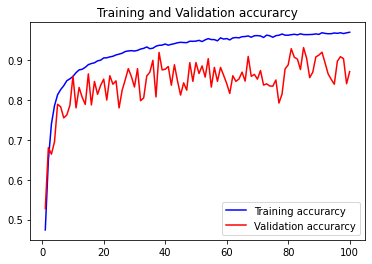

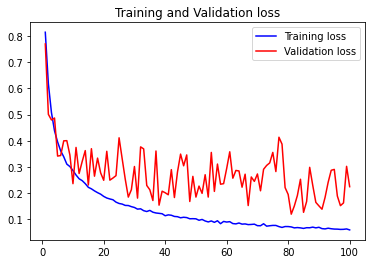

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [137]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
100/100 [==============================] - 0s 3ms/step - loss: 0.2244 - accuracy: 0.8709
Test Accuracy: 87.09375262260437


In [138]:
print("[INFO] evaluating network...")
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_binarizer.classes_))

[INFO] evaluating network...
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.57      0.73       859
           Brown spot       0.72      0.95      0.82       837
               Health       1.00      1.00      1.00       767
            Leaf smut       0.89      1.00      0.94       737

             accuracy                           0.87      3200
            macro avg       0.90      0.88      0.87      3200
         weighted avg       0.90      0.87      0.86      3200



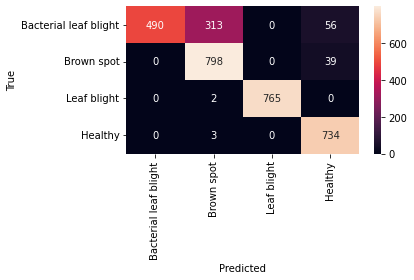

In [139]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
x_axis_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf blight', 'Healthy']
y_axis_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf blight', 'Healthy']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()